MagicError - problem with having run more than 1 simulation w/o restarting kernel. See if this could be fixed

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
%matplotlib inline 

Starting simulation at t=0. s for a duration of 1. s
100. us (0%) simulated in 16s, estimated 1d 20h 34m 32s remaining.


WARNING    neurongroup_1's variable 'h' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'm' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'n' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


1. s (100%) simulated in 17s


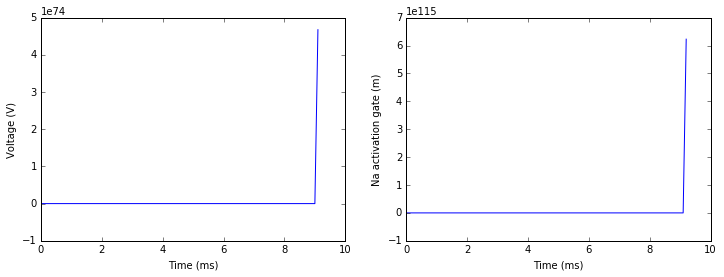

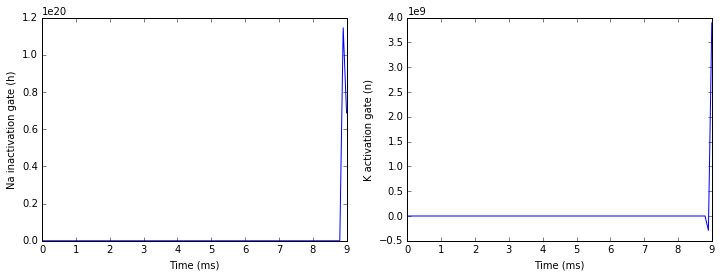

In [7]:
# NEW ATTEMPT W/ DIFF SOURCE
El=-67*mV
EK=-100*mV
ENa=50*mV
gl = (1e-4*siemens)
g_na=(0.1*siemens)
g_kd=(0.08*siemens)
Cm = (1*ufarad)

# Time constants
taue=2*ms
taui=6.8*ms

# Reversal potentials
Ee=0*mV #Eampa
Ei=-80*mV #Egaba

vr=0*mV # Didn't change from original Brian model

# Creates sinusoidal input current as TimedArray
I_freq=0.01
I_offset=0.5
I_amp=7.
tend=600
dt=.1

t_curr = np.arange(0, tend, dt)
tmp = (I_amp*np.sin(2.0*np.pi*I_freq*t_curr)+I_offset)*uamp
curr = TimedArray(tmp, dt=dt*ms) 

eqs = '''
I_e = curr(t) : amp
dv/dt = (I_e+(gl*(El-v)+ge*(Ee-v)+gi*(Ei-v)-g_na*(m*m*m)*h*(v-ENa)-g_kd*(n*n*n*n)*(v-EK)))/Cm : volt
alphah = 0.128*exp(-0.056*(mV**-1)*(v+50*mV))/ms : Hz
alpham = 0.32*(mV**-1)*(54*mV+v) / (1-exp(-0.25*(mV**-1)*(54*mV+v)))/ms : Hz
alphan = 0.032*(mV**-1)*(52*mV+v)/(1-exp(-0.2*(mV**-1)*(v+52*mV)))/ms : Hz
betah = 4/(1+exp(-0.2*(mV**-1)*(v+27*mV)))/ms : Hz
betam = 0.28*(mV**-1)*(27*mV+v) / (exp(0.2*(mV**-1)*(v+27*mV))-1)/ms : Hz
betan = 0.5*exp(-0.025*(mV**-1)*(57*mV+v))/ms : Hz
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1

dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
'''

P = NeuronGroup(40,model=eqs,threshold='v > 20*mV',reset='v=vr',refractory=3*ms,method='euler')
Pe=P[9:]
Pi=P[:8]

# parameter initialization
#P.vm = 0
P.m = 0.0529324852572
P.h = 0.596120753508
P.n = 0.317676914061
P.v=El+(randn(len(P))*5-5)*mV
P.ge=(randn(len(P))*1.5+4)*10.*nS
P.gi=(randn(len(P))*12+20)*10.*nS

# Add Synapses later
#S = Synapses(Pe, Pi, 'w : siemens', on_pre='ge += w')
#S.connect(p=0.02) # Set up w/ adjacency matrix from Adj.weighted
#S.w = we

#S = Synapses(Pi, Pe, 'w : siemens', on_pre='ge += w')
#S.connect(p=0.02) # Set up w/ adjacency matrix from Adj.weighted
#S.w = wi

trace=StateMonitor(P,True,record=0)
run(1*second, report='text')

figure(figsize=(12,4))
subplot(121)
plot(trace.t/ms,trace.v[0])
ylabel('Voltage (V)')
xlabel('Time (ms)')
subplot(122)
plot(trace.t/ms,trace.m[0])
ylabel('Na activation gate (m)') #WRONG SHAPE
xlabel('Time (ms)')

figure(figsize=(12,4))
subplot(121)
plot(trace.t/ms,trace.h[0])
ylabel('Na inactivation gate (h)') #WRONG SHAPE
xlabel('Time (ms)')
subplot(122)
plot(trace.t/ms,trace.n[0])
ylabel('K activation gate (n)') #WRONG SHAPE
xlabel('Time (ms)')
show()

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s


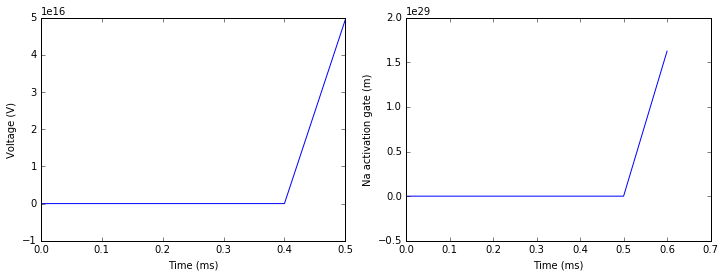

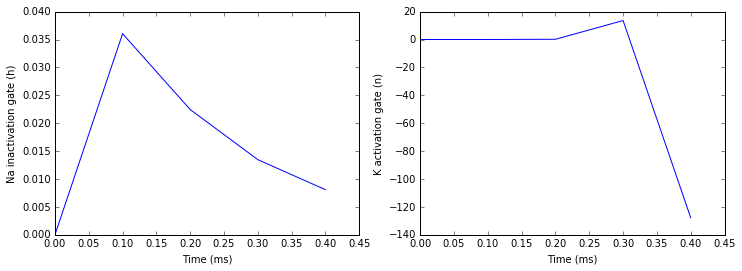

In [13]:
# MAIN ATTEMPT - using NeuronGroup, the error for NaN only happens sometimes, but spikes once
# Parameters
I_c = 10*uA
area=20000*umetre**2
Cm = (1*ufarad*cm**-2)*area
gl = (1e-4*siemens*cm**-2)*area
El=-67*mV
EK=-100*mV
ENa=50*mV
g_na=(0.1*siemens*cm**-2)*area
g_kd=(0.08*siemens*cm**-2)*area
VT=-63*mV # Didn't change from original Brian model
vr=0*mV # Didn't change from original Brian model
# Time constants
taue=2*ms
taui=6.8*ms
# Reversal potentials
Ee=0*mV #Eampa
Ei=-80*mV #Egaba
we=6*nS # excitatory synaptic weight (voltage), Didn't change from original Brian model
wi=67*nS # inhibitory synaptic weight, Didn't change from original Brian model
# The model
eqs=Equations('''
dv/dt = (I+(gl*(El-v)+ge*(Ee-v)+gi*(Ei-v)-g_na*(m*m*m)*h*(v-ENa)-g_kd*(n*n*n*n)*(v-EK)))/Cm : volt
I : amp (constant)
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens

# broken equations from Gonzalez et al.#
alpham = 0.32*(mV**-1)*(54*mV+v) / (1-exp(-0.25*(mV**-1)*(54*mV+v)))/ms : Hz
betam = 0.28*(mV**-1)*(27*mV+v) / (exp(0.2*(mV**-1)*(v+27*mV))-1)/ms : Hz
alphah = 0.128*exp(-0.056*(mV**-1)*(v+50*mV))/ms : Hz
betah = 4/(1+exp(-0.2*(mV**-1)*(v+27*mV)))/ms : Hz
alphan = 0.032*(mV**-1)*(52*mV+v)/(1-exp(-0.2*(mV**-1)*(v+52*mV)))/ms : Hz
betan = 0.5*exp(-0.025*(mV**-1)*(57*mV+v))/ms : Hz

# equations from http://briansimulator.org/demo/#
#alpham = 0.32*(mV**-1)*(13*mV-v+VT)/(exp((13*mV-v+VT)/(4*mV))-1.)/ms : Hz
#betam = 0.28*(mV**-1)*(v-VT-40*mV)/(exp((v-VT-40*mV)/(5*mV))-1)/ms : Hz
#alphah = 0.128*exp((17*mV-v+VT)/(18*mV))/ms : Hz
#betah = 4./(1+exp((40*mV-v+VT)/(5*mV)))/ms : Hz
#alphan = 0.032*(mV**-1)*(15*mV-v+VT)/(exp((15*mV-v+VT)/(5*mV))-1.)/ms : Hz
#betan = .5*exp((10*mV-v+VT)/(40*mV))/ms : Hz

# equations from http://brian2.readthedocs.io/en/2.0.1/examples/compartmental.hh_with_spikes.html#
#alpham = (0.1/mV) * (-v+25*mV) / (exp((-v+25*mV) / (10*mV)) - 1)/ms : Hz
#betam = 4 * exp(-v/(18*mV))/ms : Hz
#alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
#betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
#alphan = (0.01/mV) * (-v+10*mV) / (exp((-v+10*mV) / (10*mV)) - 1)/ms : Hz
#betan = 0.125*exp(-v/(80*mV))/ms : Hz
''')
P=NeuronGroup(40,model=eqs,threshold='v > 20*mV',reset='v=vr',refractory=3*ms,method='euler')
P.I = I_c 
Pe=P[9:]
Pi=P[:8]

S = Synapses(Pe, Pi, 'w : siemens', on_pre='ge += w')
S.connect(p=0.02) # Set up w/ adjacency matrix from Adj.weighted
S.w = we

S = Synapses(Pi, Pe, 'w : siemens', on_pre='ge += w')
S.connect(p=0.02) # Set up w/ adjacency matrix from Adj.weighted
S.w = wi

# Initialization
P.v=El+(randn(len(P))*5-5)*mV
P.ge=(randn(len(P))*1.5+4)*10.*nS
P.gi=(randn(len(P))*12+20)*10.*nS
# Record a few trace
trace=StateMonitor(P,True,record=0)
run(1*second, report='text')

figure(figsize=(12,4))
subplot(121)
plot(trace.t/ms,trace.v[0])
ylabel('Voltage (V)')
xlabel('Time (ms)')
subplot(122)
plot(trace.t/ms,trace.m[0])
ylabel('Na activation gate (m)') #WRONG SHAPE
xlabel('Time (ms)')

figure(figsize=(12,4))
subplot(121)
plot(trace.t/ms,trace.h[0])
ylabel('Na inactivation gate (h)') #WRONG SHAPE
xlabel('Time (ms)')
subplot(122)
plot(trace.t/ms,trace.n[0])
ylabel('K activation gate (n)') #WRONG SHAPE
xlabel('Time (ms)')
show()

In [ ]:
# MAIN ATTEMPT - using SpatialNeuron (single neuron)
# Demonstrates dynamics of action potential in neuron
morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')
El = -67*mV
ENa = 50*mV
EK = -100*mV
gl = 1e-4*siemens*cm**-2
gNa0 = 0.1*siemens*cm**-2
gK = 0.08*siemens*cm**-2
Cm = 1*ufarad*cm**-2
Vt = -63*mV
Vr = 0*mV

taue=2*ms
taui=6.8*ms
Ee=0*mV #Eampa
Ei=-80*mV #Egaba
we=6*nS # excitatory synaptic weight (voltage) from original Brian model
wi=67*nS # inhibitory synaptic weight from original Brian model

# Eqs work w/o excitatory/inhibitory part: +ge*(Ee-v)+gi*(Ei-v)
eqs = '''
Im = gl*(El-v)-gNa*(m*m*m)*h*(v-ENa)-gK*(n*n*n*n)*(v-EK) : volt
I : amp (point current)
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
alpham = 0.32*(mV**-1)*(54*mV+v) / (1-exp(-0.25*(mV**-1)*(54*mV+v)))/ms : Hz
betam = 0.28*(mV**-1)*(27*mV+v) / (exp(0.2*(mV**-1)*(v+27*mV))-1)/ms : Hz
alphah = 0.128*exp(-0.056*(mV**-1)*(v+50*mV))/ms : Hz
betah = 4/(1+exp(-0.2*(mV**-1)*(v+27*mV)))/ms : Hz
alphan = 0.032*(mV**-1)*(52*mV+v)/(1-exp(-0.2*(mV**-1)*(v+52*mV)))/ms : Hz
betan = 0.5*exp(-0.025*(mV**-1)*(57*mV+v))/ms : Hz
gNa : siemens/meter**2
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler",
                      refractory="m>0.4", threshold="m>0.5",
                      Cm=1*ufarad*cm**-2, Ri=35.4*ohm*cm)
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = 0.5
neuron.I = 0*amp
neuron.gNa = gNa0
M = StateMonitor(neuron, ('v','h','m','n'), record=True)
spikes = SpikeMonitor(neuron)

run(50*ms)
neuron.I[0] = 1*uA
run(3*ms)
neuron.I = 0*amp
run(50*ms)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms,M.v[0])
ylabel('Voltage (V)')
xlabel('Time (ms)')
subplot(122)
plot(M.t/ms,M.m[0])
ylabel('Na activation gate (m)')
xlabel('Time (ms)')

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms,M.h[0])
ylabel('Na inactivation gate (h)')
xlabel('Time (ms)')
subplot(122)
plot(M.t/ms,M.n[0])
ylabel('K activation gate (n)')
xlabel('Time (ms)')
show()

WARNING    Variable Ri is a shared variable but it will be recorded once for every target. [brian2.monitors.statemonitor]


Starting simulation at t=0. s for a duration of 50. ms
10. us (0%) simulated in 12s, estimated 17h 29m 51s remaining.
50. ms (100%) simulated in 17s
Starting simulation at t=53. ms for a duration of 100. ms
100. ms (100%) simulated in 9s


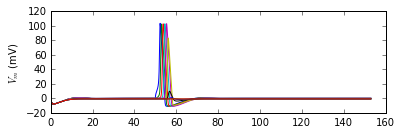

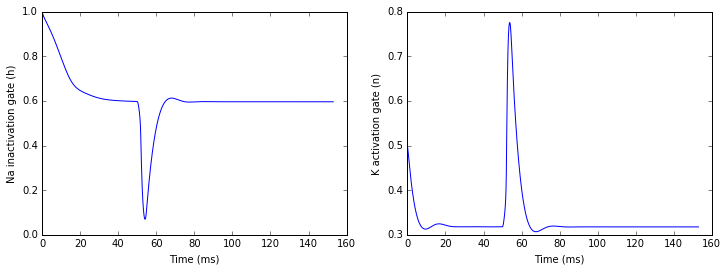

In [2]:
# TEST for SpatialNeuron and (in)activation gates
# http://brian2.readthedocs.io/en/stable/examples/compartmental.lfp.html

#from brian2 import *
defaultclock.dt = 0.01*ms
morpho = Cylinder(x=[0, 10]*cm, diameter=2*238*um, n=1000, type='axon')

C = 1*ufarad*cm**-2
El = 10.613* mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2
#taue=5*ms
#taui=10*ms

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
#Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) + gi * (Ei-v) + ge * (Ee-v) : amp/meter**2
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) : amp/meter**2
#Im = (gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) + gi * (Ei-v) + ge * (Ee-v))/C : amp

I : amp (point current) # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
#dge/dt = -ge*(1./taue) : siemens
#dgi/dt = -gi*(1./taui) : siemens
alpham = (0.1/mV) * (-v+25*mV) / (exp((-v+25*mV) / (10*mV)) - 1)/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * (-v+10*mV) / (exp((-v+10*mV) / (10*mV)) - 1)/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
previous_v : volt
'''


neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=1*uF/cm**2,
                       Ri=35.4*ohm*cm, method="exponential_euler")
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I = 0
neuron.gNa = gNa0
neuron[5*cm:10*cm].gNa = 0*siemens/cm**2
M = StateMonitor(neuron,True, record=True)

neuron.run_regularly('previous_v = v', when='start')
run(50*ms, report='text')
neuron.I[0] = 1*uA  # current injection at one end
run(3*ms)
neuron.I = 0*amp
run(100*ms, report='text')

subplot(211)
for i in range(10):
    plot(M.t/ms,M.v[i*100]/mV)
ylabel('$V_m$ (mV)')

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms,M.h[0])
ylabel('Na inactivation gate (h)') #WRONG SHAPE
xlabel('Time (ms)')
subplot(122)
plot(M.t/ms,M.n[0])
ylabel('K activation gate (n)') #WRONG SHAPE
xlabel('Time (ms)')


show()

if 0:
    # LFP recorder
    Ne = 5 # Number of electrodes
    sigma = 0.3*siemens/meter # Resistivity of extracellular field (0.3-0.4 S/m)
    lfp = NeuronGroup(Ne,model='''v : volt
                                  x : meter
                                  y : meter
                                  z : meter''')
    lfp.x = 7*cm # Off center (to be far from stimulating electrode)
    lfp.y = [1*mm, 2*mm, 4*mm, 8*mm, 16*mm]
    # Synapses are normally executed after state update, so v-previous_v = dv
    S = Synapses(neuron,lfp,model='''w : ohm*meter**2 (constant) # Weight in the LFP calculation
                                     v_post = w*(Cm_pre*(v_pre-previous_v_pre)/dt-Im_pre) : volt (summed)''')
    S.summed_updaters['v_post'].when = 'after_groups'  # otherwise v and previous_v would be identical
    S.connect()
    S.w = 'area_pre/(4*pi*sigma)/((x_pre-x_post)**2+(y_pre-y_post)**2+(z_pre-z_post)**2)**.5'

    Mlfp = StateMonitor(lfp,'v',record=True)

    subplot(212)
    for i in range(5):
        plot(M.t/ms,Mlfp.v[i]/mV)
    ylabel('LFP (mV)')
    xlabel('Time (ms)')

